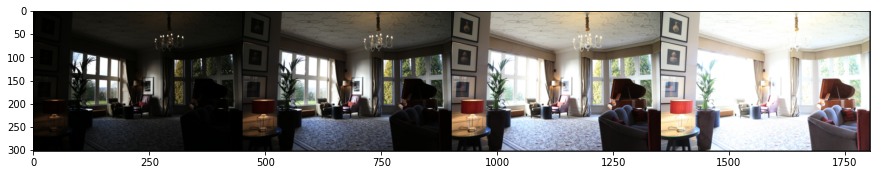

In [1]:
import matplotlib.pyplot as plt
import torch.nn
import torch.nn.functional as F

from util import *

transforms = T.Compose(
    [T.Resize(300),
    T.ToTensor()]
)

targets = load_data(manor_data, transforms)
targets = targets
B,C,H,W = targets.shape
plt.figure(figsize=(15, 15))

plot(targets)

In [2]:
targets_flat = targets.permute(0,2,3,1).reshape(-1, C)

uv = get_grid(0,1,W,H)
uv = uv.unsqueeze(0).expand(B, H, W, 2)
uv_flat = uv.reshape(-1, 2)

img_ids = torch.zeros(B,H,W).long()
for i in range(B):
    img_ids[i] = i
img_ids = img_ids.reshape(-1)

selection = torch.rand(targets_flat.shape[0])
selection_amount = 0.8
train_mask = selection > selection_amount
val_mask = selection <= selection_amount

train_targets = targets_flat[train_mask]
train_uv = uv_flat[train_mask]
train_ids = img_ids[train_mask]


val_targets = targets_flat[val_mask]
val_uv = uv_flat[val_mask]
val_ids = img_ids[val_mask]


/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


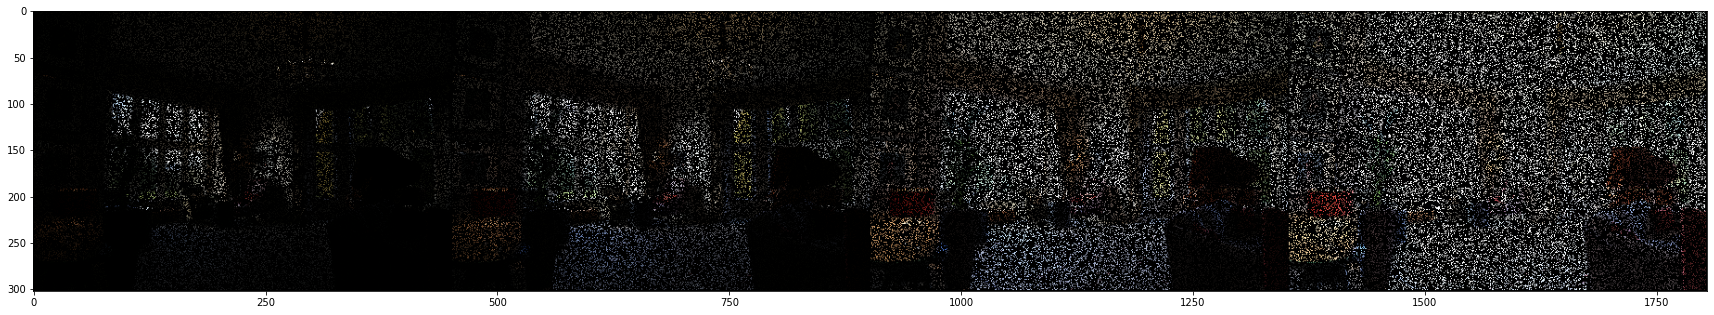

In [3]:
plt.figure(figsize=(30, 15))
train_viz = torch.zeros_like(targets_flat)
train_viz[train_mask] = train_targets
train_viz = train_viz.view(B,H,W,C).permute(0,3,1,2)
plot(train_viz)

In [4]:
batchsize = 1024*4

def CRF_(x : torch.Tensor, alpha=0.01):
    x[x<0.0] = alpha * x[x<0.0]
    x[0.0<=x<=1.0] = x[0.0<=x<=1.0]^0.45
    x[x>1.0] = -alpha/torch.sqrt(x[x>1.0])+alpha+1
    return x

def CRF(x : torch.Tensor, alpha=0.01):
    crf_x = x**0.45
    crf_x = torch.where(x<0.0, alpha*x, crf_x)
    crf_x = torch.where(x>0.0, -alpha/torch.sqrt(x)+alpha+1, crf_x)
    return crf_x

def CRF2(x : torch.Tensor, alpha=0.01):
    crf_x = torch.clamp(x,0.0,1.0)**0.45
    return crf_x

def CRF_sig(x : torch.Tensor, alpha=0.01):
    crf_x = torch.sigmoid(x)
    return crf_x

In [5]:
model = torch.nn.Sequential(
                PositionalEncoding(12),
                SimpleModule(50, 128),
                SimpleModule(128, 128),
                SimpleModule(128, 128),
                torch.nn.Linear(128,3)
                #SimpleModule(128, 3, activation=torch.nn.Ex),
            )

exp_val = torch.zeros([B,3])
#exp_val = torch.Tensor([-2,0,2,4])
#exp_val = exp_val.unsqueeze(-1)
#exp_val = exp_val.requires_grad_(True)
#exp_val = torch.nn.Parameter(exp_val)

model = HDRNetComplex(model, B)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(list(model.parameters())+[exp_val], lr=learning_rate)

loss_fn = torch.nn.MSELoss(reduction='mean')
loss_total = []
psnr_val_total = []

In [6]:
model = model.cuda()

train_uv = train_uv.cuda()
train_targets = train_targets.cuda()
train_ids = train_ids.cuda()

val_uv = val_uv.cuda()
val_targets = val_targets.cuda()
val_ids = val_ids.cuda()

model.train()
with tqdm.trange(20000) as tr:
    loss_accum = []
    for t in tr:
        batch_mask = torch.randint(train_targets.shape[0], (batchsize,)).cuda()

        x = train_uv[batch_mask]
        y = train_targets[batch_mask]
        img_id = train_ids[batch_mask]

        y_pred = model(x, img_id)

        loss = loss_fn(y_pred, y) + 0.0001*torch.mean(model.offsets**2) + 0.01*torch.mean((model.scale-1)**2)
        loss_accum.append(loss.cpu().item())
        if t % 100 == 0:
            logloss = np.mean(loss_accum)
            loss_total.append(logloss)
            loss_accum = []

            batch_mask = torch.randint(val_targets.shape[0], (batchsize,)).cuda()
            x = val_uv[batch_mask]
            y = val_targets[batch_mask]
            img_id = val_ids[batch_mask]

            y_pred = model(x, img_id)

            psnr = 10*torch.log10(1/F.mse_loss(y_pred, y)).cpu().detach()
            psnr_val_total.append(psnr)
            tr.set_postfix(loss=str(logloss), val_psnr = str(psnr))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




 50%|█████     | 10046/20000 [01:49<01:48, 91.53it/s, loss=0.14825700089335442, val_psnr=tensor(8.2864)]Exception ignored in: <generator object tqdm.__iter__ at 0x7f223c664d60>
Traceback (most recent call last):
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/tqdm/std.py", line 1195, in __iter__
    self.close()
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/tqdm/std.py", line 1301, in close
    self.display(pos=0)
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/tqdm/std.py", line 1494, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/tqdm/std.py", line 350, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-packages/tqdm/std.py", line 344, in fp_write
    fp_flush()
  File "/home/bene/projects/DirectVoxGO/.venv/lib/python3.9/site-p

KeyboardInterrupt: 

In [ ]:
linvals = get_grid(0,1,W,H).view(-1,2).cuda()
bsize = W*2
batchcount = linvals.shape[0]/bsize
result = torch.zeros((B,H,W, 3)).view(B,-1,3)

model.eval()
with torch.no_grad():
    for b in range(B):
        for bnr in range(int(batchcount)):
            bidx = bnr*bsize
            batch = linvals[bidx:bidx+bsize]
            res = model(batch, b)
            result[b,bidx:bidx+bsize] = res.cpu().detach()

result = result.view(B,H,W,3).permute(0,3,1,2)
plt.figure(figsize=(30, 15))
plot(result)

In [ ]:
plt.plot(loss_total)
plt.show()
plt.plot(psnr_val_total)
plt.show()

In [ ]:
print(model.offsets)
print(model.scale)
linvals = get_grid(0,1,W,H).view(-1,2).cuda()
bsize = W*2
batchcount = linvals.shape[0]/bsize
result = torch.zeros((H,W, 3)).view(-1,3)

model.eval()
with torch.no_grad():
    for b in range(B):
        for bnr in range(int(batchcount)):
            bidx = bnr*bsize
            batch = linvals[bidx:bidx+bsize]
            res = model.basic_net(batch)
            res = res*0.5
            res = torch.sigmoid(res)
            result[bidx:bidx+bsize] = res.cpu().detach()

result = result.view(H,W,3)
plt.figure(figsize=(30, 15))

plot(result)

tensor(16.5000)
tensor(8.1240)
